[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slayoo/seattle-2026-workshop/blob/main/part_3_units_with_pint_and_pysdm_complete.ipynb)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils pint PySDM mendeleev numba

# hacking aerosol-cloud μ-physics modeling concepts in Python
### (mini-workshop @Uni. Washington Seattle, Jan 2026)

### Part 3: dimensional analysis using Pint (and PySDM.physics)

notebook authors (alphabetically): 
- Sylwester Arabas
- Agnieszka Żaba
- Emma Ware

This notebook depicts:
- how physical quantities (both scalar and NumPy arrays) can be assigned with units using the [Pint](https://pint.readthedocs.io/) package and   
 the emergent improvement in code quality: avoiding unmaintainable comments, handling unit conversions, offering debugging and assertion tools  
- the resultant ability of Python interpretter to check correctness of any arithmetics involving physical quantities
- how the `DimensionalAnalysis` context manager from `PySDM.physics` enables both unit-aware and unit-unaware execution of the same code    (for compatibility with Numba just-in-time compilation, with SciPy numerical solvers, etc)
- how Pint's integration with matplotlib enables auto-labelling of plot axes and how it enforces consistent units of data plotted on the same axes

### • variables and arrays with Pint units

In [2]:
import pint, scipy, mendeleev, numpy

def constants(si):
    return {
        "M_a": (
            0.78 * 2 * mendeleev.N.atomic_weight * si.g / si.mole + 
            0.21 * 2 * mendeleev.O.atomic_weight * si.g / si.mole + 
            0.01 * 1 * mendeleev.Ar.atomic_weight * si.g / si.mole
        ),
        "R_str": scipy.constants.R * si.J / si.K / si.mole,
        "p0": 1025 * si.hPa,
    }

rho0 = lambda c, T: c["p0"] / (c["R_str"] / c["M_a"]) / T

SI = pint.UnitRegistry()
C = constants(SI)
T = numpy.linspace(250, 300, 5) * SI.K

print(T)
rho = rho0(C, T)
print(f"{rho:.4g}")

[250.0 262.5 275.0 287.5 300.0] kelvin
[14.48 13.79 13.17 12.59 12.07] gram * hectopascal / joule


In [3]:
assert rho.check("[density]")

In [4]:
print(rho.to_base_units())

[1.44825698944528 1.3792923709002665 1.3165972631320726 1.2593539038654606 1.2068808245377332] kilogram / meter ** 3


In [5]:
print(f"{rho.to(SI.lb / SI.ft**3):.2g}")

[0.09 0.086 0.082 0.079 0.075] pound / foot ** 3


In [6]:
mixing_ratio = 10 * SI.g / SI.kg
print(mixing_ratio.to(SI.dimensionless))

0.01 dimensionless


In [7]:
mixing_ratio + .01 * SI.kg / SI.kg

20.0 <Unit('gram / kilogram')>

### • dimensional analysis (at runtime, see Julia's [`Unitful.jl`](https://juliaphysics.github.io/Unitful.jl) for JIT-compile-time solution!) 

In [8]:
try:
    print(C["p0"] + T)
except Exception as e:
    print("FAILED!", str(e))

FAILED! Cannot convert from 'hectopascal' ([mass] / [length] / [time] ** 2) to 'kelvin' ([temperature])


### • trying to use Pint with Scipy or Numba ... 

In [9]:
find_T_for_rho_eq_1_kg_per_m3 = lambda x: rho0(C, T=x) - 1 * SI.kg / SI.m**3 

try:
    scipy.optimize.root_scalar(
        f=lambda x: rho0(C, T=x) - 1 * SI.kg / SI.m**3 ,
        x0=300 * SI.K
    )
except Exception as e:
    print("FAILED!", str(e))

FAILED! Cannot convert from 'gram * hectopascal * kelvin / joule' ([mass] * [temperature] / [length] ** 3) to 'kilogram / meter ** 3' ([mass] / [length] ** 3)


/home/user/devel/venv/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:300: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = np.asarray(x0)[()] * 1.0


In [10]:
import numba

def f(x):
    return x
    
try:
    numba.jit(f)(300 * SI.K)
except Exception as e:
    print("FAILED!", str(e))

FAILED! Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /tmp/ipykernel_69396/2300399850.py (3)

File "../../../../tmp/ipykernel_69396/2300399850.py", line 3:
<source missing, REPL/exec in use?> 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'pint.Quantity'>



### • solution: `PySDM.physics` 

In [11]:
from PySDM import physics

In [12]:
si = physics.si
c = constants(si)
scipy.optimize.root_scalar(
    f=lambda x: rho0(c, T=x) - 1 * si.kg / si.m**3 ,
    x0=300 * si.K
)

      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 362.06424736132
         method: newton

In [13]:
numba.jit(f)(300 * si.K)

300.0

In [14]:
from PySDM.physics.dimensional_analysis import DimensionalAnalysis

with DimensionalAnalysis():
    si = physics.si
    c = constants(si)
    print(rho0(c, 300 * si.K))

12.068808245377332 gram * hectopascal / joule


### • plotting with Pint

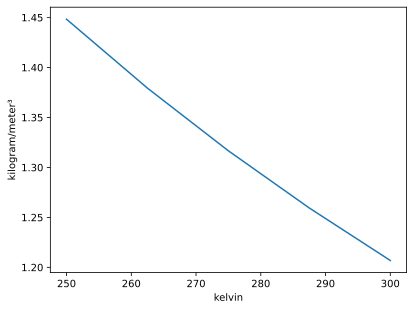

In [15]:
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

SI.setup_matplotlib()

pyplot.plot(T, rho0(C, T))
pyplot.gca().yaxis.set_units(SI.kg / SI.m**3)
show_plot()